In [1]:
!pip install joblib

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Program Files\Python311\python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import joblib


In [3]:
# Load dataset
df = pd.read_csv('data/household_power_consumption.txt', sep=';', na_values='?', low_memory=False)

# Create datetime column
df['dt'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df = df[['dt', 'Global_active_power']].rename(columns={'dt': 'ds', 'Global_active_power': 'y'})

# Convert and interpolate
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df['y'] = df['y'].interpolate(method='linear')

# Resample to hourly data
df = df.set_index('ds').resample('H').mean().reset_index()

# Drop near-zero values
df = df[df['y'] > 0.1]

# Add time-based features
df['hour'] = df['ds'].dt.hour
df['dayofweek'] = df['ds'].dt.dayofweek

# Optional: smooth the signal slightly
df['y'] = df['y'].rolling(window=3, min_periods=1).mean()

df.head()


C:\Users\M S I\AppData\Local\Temp\ipykernel_7032\2309560570.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index('ds').resample('H').mean().reset_index()


,ds,y,hour,dayofweek
0,2006-12-16 17:00:00,4.222889,17,5
1,2006-12-16 18:00:00,3.927544,18,5
2,2006-12-16 19:00:00,3.751774,19,5
3,2006-12-16 20:00:00,3.433667,20,5
4,2006-12-16 21:00:00,3.241756,21,5


In [4]:
# Select features
features = ['y', 'hour', 'dayofweek']

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Save scaler
joblib.dump(scaler, 'scaler.pkl')

# Convert to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=features)
scaled_df['ds'] = df['ds'].values  # retain datetime


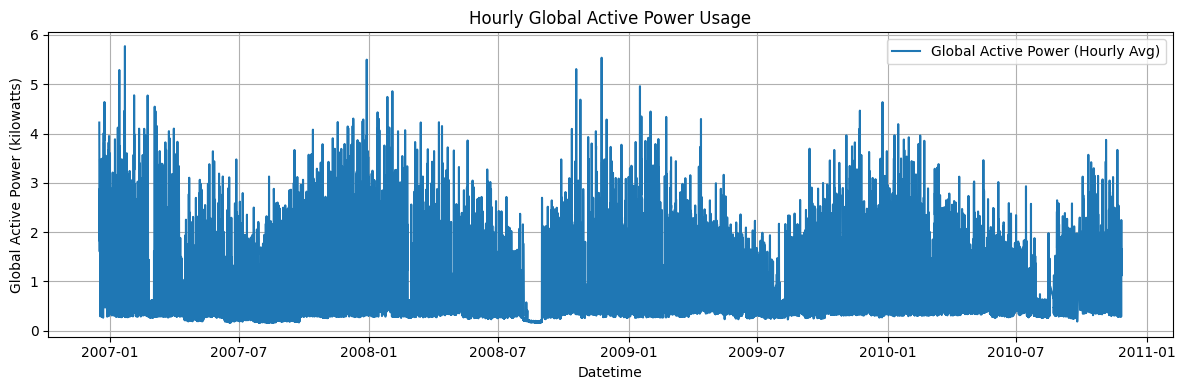

In [5]:
# Plot the hourly power consumption
plt.figure(figsize=(12, 4))
plt.plot(df['ds'], df['y'], label='Global Active Power (Hourly Avg)')
plt.title("Hourly Global Active Power Usage")
plt.xlabel("Datetime")
plt.ylabel("Global Active Power (kilowatts)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
sequence_length = 48  # 2 days

X, y = [], []
for i in range(sequence_length, len(scaled_df)):
    X.append(scaled_df.iloc[i-sequence_length:i][['y', 'hour', 'dayofweek']].values)
    y.append(scaled_df.iloc[i]['y'])

X, y = np.array(X), np.array(y)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (34541, 48, 3)
y shape: (34541,)


In [9]:
# 80/20 split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


X_train: (27632, 48, 3), X_test: (6909, 48, 3)
y_train: (27632,), y_test: (6909,)


In [10]:
model = Sequential()
model.add(Input(shape=(sequence_length, 3)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 46, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 23, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,329 (341.13 KB)

 Trainable params: 87,329 (341.13 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)


Epoch 1/100
691/691 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.0907 - val_loss: 0.0443 - learning_rate: 0.0010
Epoch 2/100
691/691 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.0522 - val_loss: 0.0386 - learning_rate: 0.0010
Epoch 3/100
691/691 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 0.0445 - val_loss: 0.0326 - learning_rate: 0.0010
Epoch 4/100
691/691 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.0396 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 5/100
691/691 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.0378 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 6/100
691/691 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 0.0362 - val_loss: 0.0320 - learning_rate: 0.0010
Epoch 7/100
691/691 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.0365 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 8/100
691/691 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 0.0354 - val_loss: 0.0275 - learning_rate: 0.0010
Epoch 9/100
691/691 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.0343 - val_loss: 0.0280 - learn

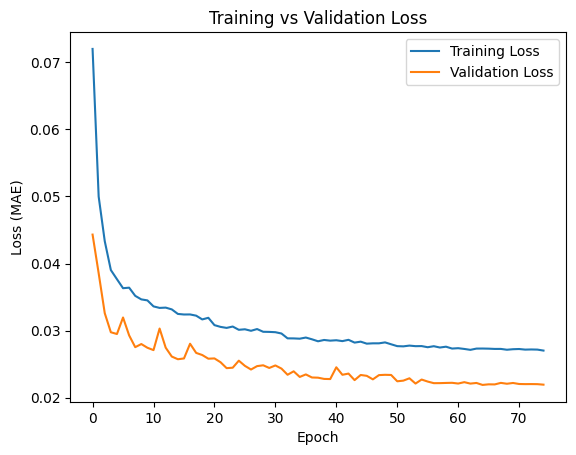

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()


In [ ]:
# Predict
y_pred = model.predict(X_test)

# Reshape
y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

# Inverse transform using only 'y' column scale
y_scaler = MinMaxScaler()
y_scaler.min_, y_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
y_test_inv = y_scaler.inverse_transform(y_test)
y_pred_inv = y_scaler.inverse_transform(y_pred)

# Metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
smape = 100 * np.mean(2 * np.abs(y_pred_inv - y_test_inv) / (np.abs(y_pred_inv) + np.abs(y_test_inv)))
accuracy = 100 - smape

# Results
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R² Score: {r2:.4f}')
print(f'SMAPE: {smape:.2f}%')
print(f'Accuracy (100 - SMAPE): {accuracy:.2f}%')


216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
MSE: 0.0288
RMSE: 0.1697
MAE: 0.1183
R² Score: 0.9250
SMAPE: 13.23%
Accuracy (100 - SMAPE): 86.77%


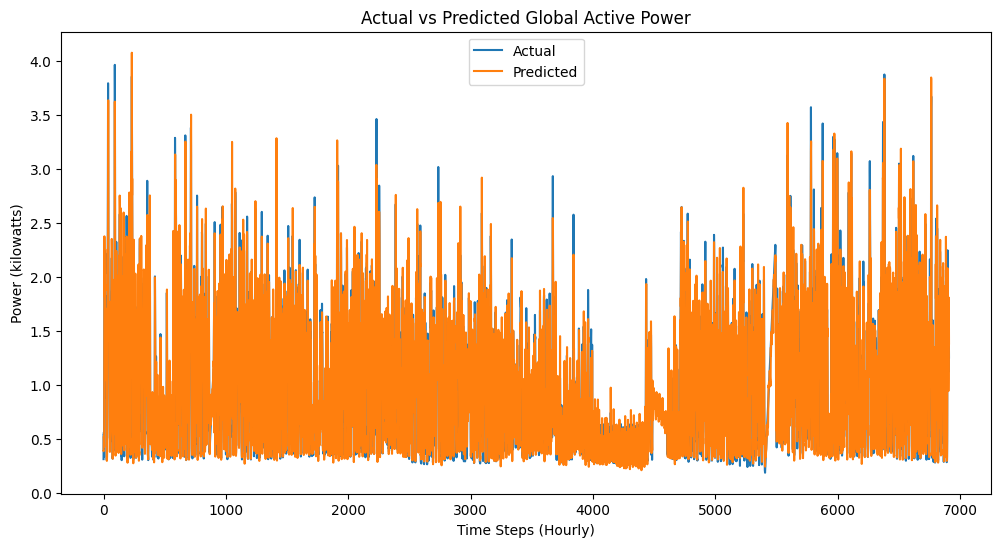

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Actual vs Predicted Global Active Power')
plt.xlabel('Time Steps (Hourly)')
plt.ylabel('Power (kilowatts)')
plt.legend()
plt.show()


In [20]:
import os
import joblib

# Paths
os.makedirs("model", exist_ok=True)
MODEL_PATH = "model/lstm_model.h5"  # using .h5 for Keras model
SCALER_PATH = "model/scaler.pkl"
SAMPLE_VALUES_PATH = "model/sample_values.pkl"
METRICS_PATH = "model/metrics.pkl"

# Save the trained Keras model
model.save(MODEL_PATH)

# Save the scaler
joblib.dump(scaler, SCALER_PATH)

# Save sample input values (e.g., first test sample for inference/demo)
sample_input = X_test[0]  # First test sample
joblib.dump(sample_input, SAMPLE_VALUES_PATH)

# Save metrics
metrics = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'smape': smape, 'accuracy': accuracy}
joblib.dump(metrics, METRICS_PATH)

print(f"Model saved to: {MODEL_PATH}")
print(f"Scaler saved to: {SCALER_PATH}")
print(f"Sample input saved to: {SAMPLE_VALUES_PATH}")
print(f"Metrics saved to: {METRICS_PATH}")

Model saved to: model/lstm_model.h5
Scaler saved to: model/scaler.pkl
Sample input saved to: model/sample_values.pkl
Metrics saved to: model/metrics.pkl
